In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from helpers.composite_helpers import *
from helpers.datasets import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Dense, Flatten
from keras import backend as K 

from scipy import interpolate
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
# directory setup

num_signal_to_inject = 0
n_features = 6 # SALAD also uses the mass feature I think


bands_dict = {"ob1": [2500, 2900],
              "sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100],
              "ob2": [4100, 4500]}

binning_scheme = np.linspace(-3.5, 3.5, 50)

feta_dir = "/global/home/users/rrmastandrea/FETA/"
dataset_config_string = f"LHCO_{num_signal_to_inject}sig_f"
path_to_minmax = f"{feta_dir}/LHCO_STS/data/col_minmax.npy"
col_minmax = np.load(path_to_minmax)

    
exp_dir = os.path.join(feta_dir, dataset_config_string)
data_dir = os.path.join(exp_dir, "data")


In [3]:
# load in and prepare the extra herwig sr samples
# load in the extra herwig SR samples

def get_lhco_loc(filepath):
    
    print(filepath)
    df = pd.read_hdf(filepath)
    # make_slim(df, directory, lhco_filename)

    # Reorder the features such that the jets are ordered according to their invariant masses
    jet_order_mask = df['mj1'] < df['mj2']
    inverted_keys = ['pxj2', 'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'pxj1', 'pyj1', 'pzj1', 'mj1',
                     'tau1j1', 'tau2j1', 'tau3j1']
    proper_order = df.loc[jet_order_mask]
    improper_order = df.loc[~jet_order_mask]
    improper_order.columns = inverted_keys
    df = pd.concat((proper_order, improper_order))

    for jet in ['j1', 'j2']:
        df[f'pt{jet}'] = np.sqrt(df[f'px{jet}'] ** 2 + df[f'py{jet}'] ** 2)
        df[f'eta{jet}'] = np.arcsinh(df[f'pz{jet}'] / df[f'pt{jet}'])
        df[f'phi{jet}'] = np.arctan2(df[f'py{jet}'], df[f'px{jet}'])
        df[f'p{jet}'] = np.sqrt(df[f'pz{jet}'] ** 2 + df[f'pt{jet}'] ** 2)
        df[f'e{jet}'] = np.sqrt(df[f'm{jet}'] ** 2 + df[f'p{jet}'] ** 2)

    data = df[['mj1', 'mj2']].copy()
    data['mj2-mj1'] = data['mj2'] - data['mj1']
    data[r'$\tau_{21}^{j_1}$'] = df['tau2j1'] / df['tau1j1']
    data[r'$\tau_{32}^{j_1}$'] = df['tau3j1'] / df['tau2j1']
    data[r'$\tau_{21}^{j_2}$'] = df['tau2j2'] / df['tau1j2']
    data[r'$\tau_{32}^{j_2}$'] = df['tau3j2'] / df['tau2j2']
    # data = pd.DataFrame()
    data[r'$p_t^{j_1}$'] = df['ptj1']
    data[r'$p_t^{j_2}$'] = df['ptj2']
    phi_1 = df['phij1']
    phi_2 = df['phij2']
    delPhi = np.arctan2(np.sin(phi_1 - phi_2), np.cos(phi_1 - phi_2))
    data[r'$dR_{jj}$'] = ((df['etaj1'] - df['etaj2']) ** 2 + delPhi ** 2) ** (0.5)

    data['delPhi'] = abs(delPhi)
    data['delEta'] = abs(df['etaj1'] - df['etaj2'])

    data['mjj'] = calculate_mass(
        np.sum([df[[f'ej{i}', f'pxj{i}', f'pyj{i}', f'pzj{i}']].to_numpy() for i in range(1, 3)], 0))
    return data.dropna()


new_herwig_samps_path = "/clusterfs/ml4hep/rrmastandrea/LHCO/events_anomalydetection_DelphesHerwig_qcd_extra_inneronly_features.h5"

df_new_herwig = get_lhco_loc(new_herwig_samps_path)
data_herwig_sr = select_lhco_features(df_new_herwig, feature_type = 0).to_numpy()


/clusterfs/ml4hep/rrmastandrea/LHCO/events_anomalydetection_DelphesHerwig_qcd_extra_inneronly_features.h5


In [4]:
"""
"""
"""
LOAD IN THE DATASETS AND PROCESS
"""
"""
"""

npull_dataset_train_sim = ToyDataset(data_dir, "train_sim.npy")
npull_dataset_val_sim = ToyDataset(data_dir, "val_sim.npy")
npull_dataset_train_dat = ToyDataset(data_dir, "train_dat.npy")
npull_dataset_val_dat = ToyDataset(data_dir, "val_dat.npy")
classif_train_dat = ToyDataset(data_dir, "classif_train_dat.npy")

print("Num SIM events in SB:", len(npull_dataset_train_sim)+len(npull_dataset_val_sim))
print("Num DAT events in SB:", len(npull_dataset_train_dat)+len(npull_dataset_val_dat))
print()

# Preprocess the data
print("Preproccessing data...")
print()
dataset_train_sim = npull_dataset_train_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_val_sim = npull_dataset_val_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_train_dat = npull_dataset_train_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_val_dat = npull_dataset_val_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])

dataset_sr_dat = classif_train_dat.pull_from_mass_range([bands_dict["sr"]])


dataset_train_sim = minmaxscale(dataset_train_sim.data, col_minmax, lower = 0, upper = 1, forward = True)
dataset_val_sim = minmaxscale(dataset_val_sim.data, col_minmax, lower = 0, upper = 1, forward = True)
dataset_train_dat = minmaxscale(dataset_train_dat.data, col_minmax, lower = 0, upper = 1, forward = True)
dataset_val_dat = minmaxscale(dataset_val_dat.data, col_minmax, lower = 0, upper = 1, forward = True)

dataset_sr_sim = minmaxscale(data_herwig_sr, col_minmax, lower = 0, upper = 1, forward = True)
dataset_sr_dat = minmaxscale(dataset_sr_dat.data, col_minmax, lower = 0, upper = 1, forward = True)

Num SIM events in SB: 401354
Num DAT events in SB: 278761

Preproccessing data...



## Plot the features to make sure all is well

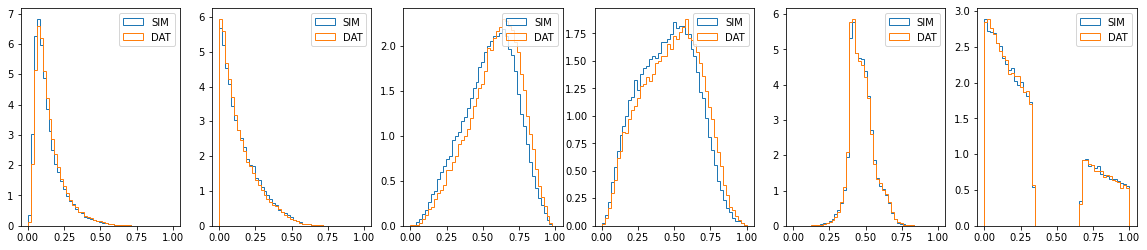

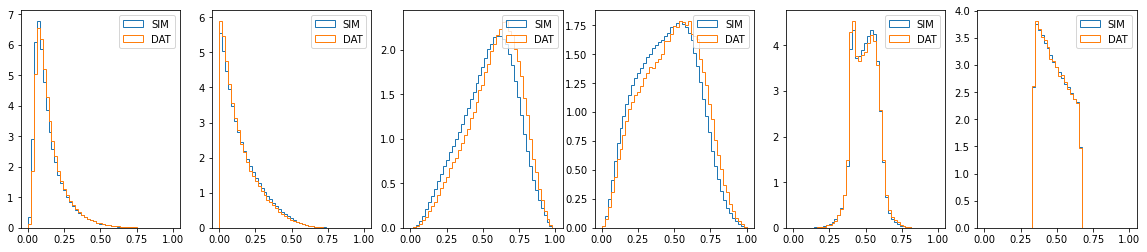

In [6]:
fig, ax = plt.subplots(1, n_features, figsize = (20, 4))
bins = np.linspace(0, 1, 50)

# plot SB

for i in range(n_features):

    ax[i].hist(dataset_val_sim[:,i], bins, label = "SIM", histtype = "step", density = True)
    ax[i].hist(dataset_val_dat[:,i], bins, label = "DAT", histtype = "step", density = True)
    
    ax[i].legend()

fig.show()


# plot SR

fig, ax = plt.subplots(1, n_features, figsize = (20, 4))

for i in range(n_features):

    ax[i].hist(dataset_sr_sim[:,i], bins, label = "SIM", histtype = "step", density = True)
    ax[i].hist(dataset_sr_dat[:,i], bins, label = "DAT", histtype = "step", density = True)
    
    ax[i].legend()

fig.show()




## Run SALAD

In [7]:
# Set up datasets

stored_weights = {}

def get_weights(data, model):
    yhat = model.predict(data, batch_size=128)
    return np.squeeze(yhat/(1 - yhat))


X_SALAD_sb_train = np.concatenate([dataset_train_sim, dataset_train_dat])
Y_SALAD_sb_train = np.concatenate([np.zeros(len(dataset_train_sim)), np.ones(len(dataset_train_dat))])

X_SALAD_val = np.concatenate([dataset_val_sim, dataset_val_dat])
Y_SALAD_val = np.concatenate([np.zeros(len(dataset_val_sim)),np.ones(len(dataset_val_dat))])



In [8]:
print('Training...')

tf.keras.backend.clear_session()
model_SALAD_sb = Sequential()
model_SALAD_sb.add(Dense(100, input_dim=n_features, activation='relu')) 
model_SALAD_sb.add(Dense(100, activation='relu'))
model_SALAD_sb.add(Dense(100, activation='relu'))
model_SALAD_sb.add(Dense(1, activation='sigmoid'))
model_SALAD_sb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

EPOCHS = 50
PATIENCE = 10
BATCH_SIZE = 256


earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint(f'SALAD_models/{num_signal_to_inject}.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=PATIENCE, verbose=1, epsilon=1e-7, mode='min')


hist_SALAD_sb = model_SALAD_sb.fit(
    X_SALAD_sb_train, Y_SALAD_sb_train, epochs=EPOCHS,
    batch_size=int(BATCH_SIZE), verbose=0, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_SALAD_val, Y_SALAD_val)
)


print("Done training!")


Training...

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Done training!


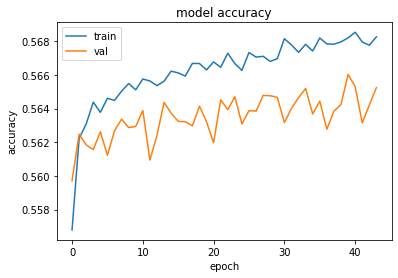

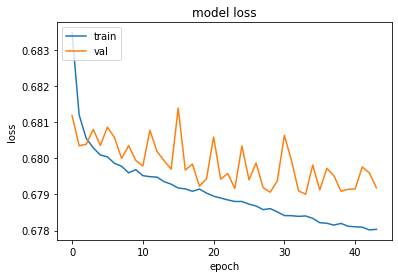

In [9]:

plt.plot(hist_SALAD_sb.history['accuracy'])
plt.plot(hist_SALAD_sb.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

     
plt.plot(hist_SALAD_sb.history['loss'])
plt.plot(hist_SALAD_sb.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
model_SALAD_sb.load_weights(f'SALAD_models/{num_signal_to_inject}.mdl_wts.hdf5')
print("Evaluating at best val loss epoch:", np.argmin(hist_SALAD_sb.history['val_loss']))

Evaluating at best val loss epoch: 33


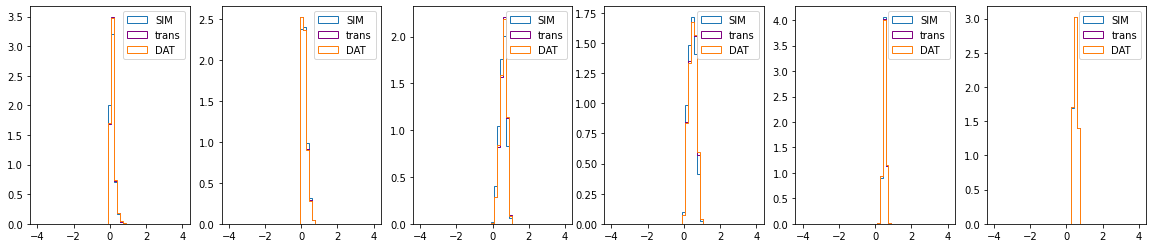

In [11]:
# plot with weights
plot_weights =  get_weights(dataset_sr_sim, model_SALAD_sb)


fig, ax = plt.subplots(1, n_features, figsize = (20, 4))

bins = np.linspace(-4, 4, 50)

for i in range(n_features):

    ax[i].hist(dataset_sr_sim[:,i], bins, label = "SIM", histtype = "step", density = True)
    ax[i].hist(dataset_sr_sim[:,i],  bins, weights = plot_weights, histtype = "step", color = "purple", label = "trans", density = True)
    ax[i].hist(dataset_sr_dat[:,i], bins, label = "DAT", histtype = "step", density = True)
    ax[i].legend()

fig.show()





In [ ]:
def analyze_band_transform_with_weights(dir_to_save, idd, 
                                        train_samp_1, train_samp_2, 
                                        weights_samp_1, weights_samp_2,
                                        test_samp_1, test_samp_2, 
                                        n_features, n_epochs, 
                                        batch_size, lr, patience, device, 
                                        update_epochs = 1, early_stop = True, visualize = True, seed = None):
    
    
    # save the best model
    val_loss_to_beat = 10000
    best_epoch = -1
    
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
                    
    dense_net = NeuralNet(input_shape = n_features)
    criterion = F.binary_cross_entropy #nn.BCELoss()
    optimizer = torch.optim.Adam(dense_net.parameters(), lr=lr)

    dense_net.to(device)
    
    if early_stop:
        early_stopping = EarlyStopping(patience=patience)
    
    # transformed SIM has label 0, DAT has label 1
    # make the input and output data
    nn_train_data = np.concatenate((train_samp_1, train_samp_2))
    nn_train_labs = np.concatenate((torch.zeros((train_samp_1.shape[0], 1)), torch.ones((train_samp_2.shape[0],1))))
    nn_train_weights =  np.concatenate((weights_samp_1, weights_samp_2))
    
    print(nn_train_labs.shape, nn_train_weights.shape)

    # get CLASS weights
    class_weights = class_weight.compute_class_weight('balanced', np.unique(nn_train_labs.reshape(-1)), nn_train_labs.reshape(-1))
    class_weights = dict(enumerate(class_weights))
    print(class_weights)
    
    # train-test split
    val_size = 0.2
    
    # train-val split
    X_train, X_val, w_train, w_val, y_train, y_val = train_test_split(nn_train_data, nn_train_weights, nn_train_labs, test_size=val_size)
    
    # if no test data provided, use the val data
    if (test_samp_1 is None) or (test_samp_2 is None):
        print("Using val data as test data...")
        X_test = X_val
        y_test = y_val
    else:
        nn_test_data = np.concatenate((test_samp_1, test_samp_2))
        nn_test_labs = np.concatenate((torch.zeros((test_samp_1.shape[0], 1)), torch.ones((test_samp_2.shape[0],1))))
        # shuffle the data
        nn_train_data, nn_train_labs = shuffle(nn_train_data, nn_train_labs)
        X_test, y_test = shuffle(nn_test_data, nn_test_labs)
    
    print("Train data, labels shape:", X_train.shape, y_train.shape)
    print("Val data, labels shape:", X_val.shape, y_val.shape)
    print("Test data, labels  shape:", X_test.shape, y_test.shape)
   
    # send to device
    X_train = np_to_torch(X_train, device)
    X_val = np_to_torch(X_val, device)
    X_test = np_to_torch(X_test, device)
    y_train = np_to_torch(y_train, device)
    y_val = np_to_torch(y_val, device)
    w_train = np_to_torch(w_train, device)
    w_val = np_to_torch(w_val, device)

    epochs, epochs_val = [], []
    losses, losses_val = [], []

    for epoch in tqdm(range(n_epochs)):
        # batching
        indices_list = torch.split( torch.randperm( X_train.shape[0] ), batch_size )
        # initialise lists to store batch stats
        losses_batch_per_e = []
        
        for i, indices in enumerate( indices_list ): # going through the batches
            # calculate the loss, backpropagate
            optimizer.zero_grad()
            
            batch_data = X_train[indices]
            batch_labels = y_train[indices]
            batch_weights_salad = w_train[indices]
            
            # get the weights
            batch_weights_class = (torch.ones(batch_labels.shape, device=device)
                        - batch_labels)*class_weights[0] \
                        + batch_labels*class_weights[1]
            
            batch_weights = batch_weights_salad*batch_weights_class


            loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses_batch_per_e.append(loss.detach().cpu().numpy())

        epochs.append(epoch)
        losses.append(np.mean(losses_batch_per_e))
        
        # validation
        if epoch % update_epochs == 0:
            
            with torch.no_grad():
                # batching
                val_indices_list = torch.split( torch.randperm( X_val.shape[0] ), batch_size )
                # initialise lists to store batch stats
                val_losses_batch_per_e = []

                for i, indices in enumerate( val_indices_list ): # going through the batches
                    # calculate the loss, backpropagate
                    optimizer.zero_grad()
                    
                    batch_data = X_val[indices]
                    batch_labels = y_val[indices]
                    batch_weights_salad = w_val[indices]

                    # get the weights
                    batch_weights_class = (torch.ones(batch_labels.shape, device=device)
                                - batch_labels)*class_weights[0] \
                                + batch_labels*class_weights[1]
                    
                    batch_weights = batch_weights_salad*batch_weights_class

                    
                    val_loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights) 

                    val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

            epochs_val.append(epoch)
            losses_val.append(np.mean(val_losses_batch_per_e))
            
            # see if the model has the best val loss
            if np.mean(val_losses_batch_per_e) < val_loss_to_beat:
                val_loss_to_beat = np.mean(val_losses_batch_per_e)
                # save the model
                model_path = f"{dir_to_save}/.{idd}_best_model.pt"
                torch.save(dense_net, model_path)
                best_epoch = epoch
                
            if early_stop:
                early_stopping(np.mean(val_losses_batch_per_e))
                
        if early_stopping.early_stop:
            break

    print("Done training!")
    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(epochs, losses)
        ax.plot(epochs_val, losses_val, label = "val")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(idd)
        fname = f"{dir_to_save}/losses_{idd}"
        fig.savefig(fname)

    # evaluate
               
    
    # load in the model with the best val loss
    
    print(f"Loading in best model for {model_path}, val loss {val_loss_to_beat} from epoch {best_epoch}")
    dense_net_eval = torch.load(model_path)
    dense_net_eval.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        outputs = dense_net_eval(X_test).detach().cpu().numpy()
        predicted = np.round(outputs)

        # calculate auc 
        auc = roc_auc_score(y_test, outputs)
        fpr, tpr, _ = roc_curve(y_test, outputs)

    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title("ROC: " + str(auc))
        fname = f"{dir_to_save}/roc_{idd}"
        fig.savefig(fname)
        
    np.save(f"{dir_to_save}/fpr_{idd}", fpr)
    np.save(f"{dir_to_save}/tpr_{idd}", tpr)
        
    if auc < 0.5:
        auc = 1.0 - auc
    
    return auc



In [ ]:
epochs_NN =  100
batch_size_NN = 128
lr_NN = 0.001
patience_NN = 10

import torch
import os
from numba import cuda 


os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

analyze_band_transform_with_weights(".", "salad", dataset_sr_sim, dataset_sr_dat,
                       plot_weights.reshape(-1, 1), np.ones((dataset_sr_dat.shape[0],1)),
                       dataset_sr_sim, dataset_sr_dat, n_features, epochs_NN, batch_size_NN, lr_NN, 
                       patience_NN, device )




